### Import libraries

In [2]:
from time import time
import pandas as pd
import numpy as np
from pythainlp import word_tokenize, sent_tokenize
from tensorflow import set_random_seed
import  matplotlib.pyplot as plt
import statistics

import re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, CuDNNLSTM, Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.utils import to_categorical

import scikitplot as skplt
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# for jupyter darktheme
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

Using TensorFlow backend.


### Import data

In [6]:
# make dataframe to show max column width
pd.set_option('display.max_colwidth',-1)

In [7]:
df = pd.read_csv(r'./data/all_hosp.csv')
df = df.rename(columns = {'0':"comment_th", 
                          '1':"score",
                          '3':"hospital"})
df.drop(columns='2', inplace=True)

#### Visualize the scraped text

In [8]:
df.head()

,comment_th,score,hospital
0,ผมเคยไปทำเลสิกที่นี้ ดีมากครับตอนนี้ผ่ามาจะ2ปีแล้วยังไม่มีผลค้างเคียงอะไรและราคาก็ถูกดีด้วย ตอนผ่าอาจจะดูน่ากลัวไปซะหน่อย แต่พอถึงเวลาผ่าจริงๆแล้วไม่รู้สึกเจ็บเลยครับ เพราะมีการหยอดยาชาก่อนผ่า,4,rama
1,รักษามาหลายปีแล้วตั้งแต่อายุ14 ตอนนี้จะจบปริญญาตรีแล้ว ตั้งแต่นอนแอดมิดที่ รพ จนหายดีออกมาใช้ชีวิตได้เป็นปกติ โดยเฉพาะคลินิกพรีเมี่ยม ไม่ต้องรอนาน มีความสะดวกรวดเร็วทุกขั้นตอนตั้งแต่จ่ายเงินไปถึงจ่ายยา ค่ารักษาไม่ได้แพงเกินไปเมื่อเทียบเท่ากับเอกชนหลายๆที่ บริการดีมากๆ คุณหมอดูแลเอาใจใส่ดี อยากให้ทุกคนมารักษาที่นี่,5,rama
2,ที่ตึกพระเทพชั้น 2 สถานที่เครื่องมือดูทันสมัย \rแต่ที่ห้องวัดความดัน มีคนที่วัด(คิดว่าไม่ใช่พยาบาลเพราะใส่ชุดสีม่วง) ชอบดุคนที่มาวัด พูดเสียงแข็งใส่คนที่มาวัดความดัน ทั้งๆที่พยาบาลอีกคนที่ใส่ชุดพยาบาลพูดเพราะ อยากให้ปรับปรุง \r มาหาหมอที่แผนกศัลยกรรม อาจารย์หมอตรวตแล้วบอกต้องผ่าตัด บอกแค่ว่าต้องผ่าตัดถึงจะหายตอนนั้นช็อคเรื่องผ่าตัดอยู่เลยไม่ได้ถามอะไรเลย แล้วหมอกก็ไปเลยไม่ได้บอกว่าจริงๆเป็นอะไร ระยะไหน (ริดสีดวง) แล้วก็นัดวันผ่า พยาบาลที่นัดคิวก็ไม่สนเวลาเราทวนสิ่งที่บอกมาว่าถูกต้องไหม บอกแค่ว่าตามนั้นแหละ สรุปแล้วเหมือนจะดีแต่รอดูช่วงผ่าตัดก่อน,3,rama
3,"Its a public hospital so service is bad (nurses are completely unfriendly and doctors have god complex plus horrifying bed side manner) but they will keep you alive (nothing to do with quality of life) with decent drug collection. Young doctors are generally very friendly but they are busy all the time due to the amount of patients (like canned tuna) so don't expect them to spend too much time diagnosing you. You have to come early in the morning to ensure you're in queue and the wait 1-2 (bad days) hours behind schedule to get to see the doctor for < 15 min or less (all together door to door 8-9hrs). \r Additionally you can call all the 8 numbers on the websites from normal clinic to Premium and wait 15 minutes on each number just for them to hang up on you or divert you elsewhere then hang up on you.....\r Worst are the guys doing the schedule because they are very consistent in demonstrating the inability to manage schedules (or not) because you will ""always"" have to wait 1-2 hours ""after"" your appointment schedule to see the doctor but they also cant tell you that so you cant go anywhere and have to hang around the front door. \r In the better days you will get to sit inside the doctor's room to wait because the doctor is no where to be found and nobody will know when he/she will come back. If you ask the nurse they will give you the ""i dont know and I couldnt care less"" look and turn away in annoyance. \r But yes, they have great ability (the doctors definitely know what they are doing) to use ur tax fund to keep you alive, two stars for that!!\r Updated review for ER: The best ER u can probably find in Bangkok as they are 24hrs fully staffed with specialty doctors (not just general doctors like other hospitals during off business hours). They are jammed packed but they are fully equipped and by that I mean they have CT scanner in the ER room - this is not something we find everywhere. Doctors know what they are doing and fully equipped with the tools to keep u alive.\r Even better update:\r Just decided to go for full blown annual health check at Rama (Feb 2016) and here are the pros and cons:\r Cons:\rAs a foreigner who pays tax in Thailand ur sort of half screwed. They are not equipped to handle foreign language so if u cant google medical terms properly u might go home thinking everything is perfect when its not...A less life threatening case is that if u pay tax to Thailand ur entitled to Thai citizen price 30% less or so which is surprisingly logical BUT not without flaws...u have to bring the ""physical"" ""original"" tax receipt from revenue dept to show then which u DONT get if u file electronically....so....who does NOT file electronically? I dont know one....maybe my parents but they're 75....\r Pros:\rOmg its a very pleasant surprise that this clinic operates with the speed, manner, and professionalism that 

### Data Preprocess

In [9]:
# Transform the score only into positive (1) and negative (0)

def pos_neg(x):
    if x <= 3:
        x = 0
    else:
        x = 1
    return x

df.score = df.score.apply(pos_neg)

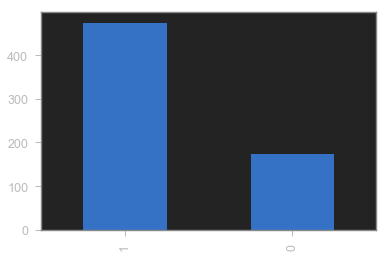

In [10]:
df.score.value_counts().plot(kind='bar')

In [11]:
df.head(2)

,comment_th,score,hospital
0,ผมเคยไปทำเลสิกที่นี้ ดีมากครับตอนนี้ผ่ามาจะ2ปีแล้วยังไม่มีผลค้างเคียงอะไรและราคาก็ถูกดีด้วย ตอนผ่าอาจจะดูน่ากลัวไปซะหน่อย แต่พอถึงเวลาผ่าจริงๆแล้วไม่รู้สึกเจ็บเลยครับ เพราะมีการหยอดยาชาก่อนผ่า,1,rama
1,รักษามาหลายปีแล้วตั้งแต่อายุ14 ตอนนี้จะจบปริญญาตรีแล้ว ตั้งแต่นอนแอดมิดที่ รพ จนหายดีออกมาใช้ชีวิตได้เป็นปกติ โดยเฉพาะคลินิกพรีเมี่ยม ไม่ต้องรอนาน มีความสะดวกรวดเร็วทุกขั้นตอนตั้งแต่จ่ายเงินไปถึงจ่ายยา ค่ารักษาไม่ได้แพงเกินไปเมื่อเทียบเท่ากับเอกชนหลายๆที่ บริการดีมากๆ คุณหมอดูแลเอาใจใส่ดี อยากให้ทุกคนมารักษาที่นี่,1,rama


In [12]:
# Text Proprocessing

df["comment_th"] = df["comment_th"].apply(lambda x: re.sub(r'http\S+', '', x)) # remove website
df["comment_th"] = df["comment_th"].apply(lambda x: x.replace('/', '')) # remove "/"
df["comment_th"] = df["comment_th"].apply(lambda x: x.replace("'\'", '')) # remove "\"
df["comment_th"] = df["comment_th"].apply(lambda x: x.replace(":", '')) # remove ":"
df["comment_th"] = df["comment_th"].apply(lambda x: x.replace(" น ", ''))
df["comment_th"] = df["comment_th"].apply(lambda x: x.replace("฿", '')) # remove น as it resulted from remove the time in TH
df["comment_th"] = df["comment_th"].apply(lambda x: re.sub(r'\d+', '', x)) # remove number
df["comment_th"] = df["comment_th"].apply(lambda x: re.sub(r'\s+', ' ', x)) # remove multiple spaces and return single space
df["comment_th"] = df["comment_th"].apply(lambda x: re.sub(r"[,@\'?\.$%_!]", '', x)) # remove punctuation

In [13]:
# sampling comment to check the comment

for i in df.comment_th.sample().index:
    ment = df.comment_th[i]
    print(i, ment)

418 เป็นสถานพยาบาลที่มีผู้ป่วยอาวุโสจำนวนมารับการรักษา บริการดีจัดระบบคิวได้ดีมาก ซึ่งสะดวกมากสำหรับผู้ป่วยที่เคยมา แล้ว แต่ผู้ป่วยใหม่ค่อนข้างจะลำบากมากเรื่องระบบการให้บริการต่างๆที่แยกส่วน หาflow chartการให้บริการเพื่ออ่านให้เข้าใจยากมาก ถามประชาสัมพันธ์ก็ตอบสั้นๆไม่ค่อยอธิบายมาก แต่ก็สรุปว่าบริการดีกว่าต่างจังหวัดมากครับ โดยเฉพาะเมื่อเข้าถึงนายแพทย์คุณหมอทั้งหลายใจดีเหลือเกิน อธิบายดีและรักษาอย่างสุดฤทธิ์สุดเดช ไม่ยอมแพ้ง่ายๆ ขอยกย่องนับถือครับ


### Tokenization

In [14]:
# Use tokenization from pythainlp

df["token"] = df.comment_th.apply(word_tokenize) # create new column with a list of Thai tokenized word

corpus = [df.token[i][j] for i in range(len(df.token)) for j in range(len(df.token[i]))]
unique_word = list(set(corpus)) # create list of unique word
unique_word_count = len(unique_word) # count unique word

tokenizer = Tokenizer(num_words=unique_word_count+1) 
tokenizer.fit_on_texts(df.token.values) # fit the Thai word

df["length"] = [len(i) for i in df.token]
max_length = max([len(i) for i in df.token]) # find the maximum length of the comment
mean_length = int(round(statistics.mean([len(i) for i in df.token]),0))

### Build Train Test Dataset

In [15]:
df_X_train, X, y_train, y = train_test_split(
        df, df.score, test_size=0.2, random_state=28, stratify=df.score) 

# create X_validate and X_test using 10% of the dataset, respectively
df_X_validate, df_X_test, y_validate, y_test = train_test_split(
        X, y, test_size=0.5, random_state=28, stratify=y) 

# convert the token into sequence for padding
X_train = tokenizer.texts_to_sequences(df_X_train['token'].values)
X_test = tokenizer.texts_to_sequences(df_X_test['token'].values)
X_validate = tokenizer.texts_to_sequences(df_X_validate['token'].values)

# padd all sequences into the same length
X_train = pad_sequences(X_train, mean_length)
X_test = pad_sequences(X_test, mean_length)
X_validate = pad_sequences(X_validate, mean_length)

# create dummy variable that will be use in Keras
y_train_dummy = pd.get_dummies(y_train) 
y_validate_dummy = pd.get_dummies(y_validate)
y_test_dummy = pd.get_dummies(y_test)

In [96]:
# create X_train using 80% of the dataset
# df_X_train, X, y_train, y = train_test_split(
#         df, df.score, test_size=0.2, random_state=28) 

# # create X_validate and X_test using 10% of the dataset, respectively
# df_X_validate, df_X_test, y_validate, y_test = train_test_split(
#         X, y, test_size=0.5, random_state=28) 

# # convert the token into sequence for padding
# X_train = tokenizer.texts_to_sequences(df_X_train['comment_th'].values)
# X_test = tokenizer.texts_to_sequences(df_X_test['comment_th'].values)
# X_validate = tokenizer.texts_to_sequences(df_X_validate['comment_th'].values)

# # padd all sequences into the same length
# X_train = pad_sequences(X_train, max_length)
# X_test = pad_sequences(X_test, max_length)
# X_validate = pad_sequences(X_validate, max_length)

# # create dummy variable that will be use in Keras
# y_train_dummy = pd.get_dummies(y_train) 
# y_validate_dummy = pd.get_dummies(y_validate)
# y_test_dummy = pd.get_dummies(y_test)

### Model Hypterparameters tuning

In [97]:
# Use sigmoid as the last activation function because the output is binary

np.random.seed(28)
set_random_seed(28)

embed_dim = 100 # number of dimension for each token

# create function of the LSTM model to search for optimal parameters
def create_model_sigmoid(lstm_out=8, lstm_out2=8, lstm_out3=8, lstm_out4 = 8,
                         dropout_rate=0.1, hidden=0, hidden2=0, hidden3=0):
    model = Sequential()
    model.add(Embedding(unique_word_count+1, embed_dim, input_length = mean_length))
    for layer in range(hidden):
        model.add((CuDNNLSTM(lstm_out, return_sequences=True)))
        for layer in range(hidden2):
            model.add((CuDNNLSTM(lstm_out2, return_sequences=True)))
            for layer in range(hidden3):
                model.add((CuDNNLSTM(lstm_out3, return_sequences=True)))
    model.add((CuDNNLSTM(lstm_out4)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='RMSprop', metrics = ['accuracy'])
    return model

model_sigmoid = KerasClassifier(build_fn=create_model_sigmoid, verbose=1, epochs=100)

In [98]:
# list of value for parameters search

lstm_out = [8,16]
lstm_out2 = [8,16]
lstm_out3 = [8,16,32]
lstm_out4 = [8,16,32]
dropout_rate = [0.3, 0.4, 0.5]
batch_size = [8]
hidden = [0,1,2]
hidden2 = [0,1,2]
hidden3 = [0,1,2]

param_grid = dict(lstm_out=lstm_out,
                  lstm_out2=lstm_out2,
                  lstm_out3=lstm_out3,
                  lstm_out4=lstm_out4,
                  hidden = hidden,
                  hidden2 = hidden2,
                  hidden3 = hidden3,
                  dropout_rate=dropout_rate, 
                  batch_size=batch_size)

# Random Search
grid = RandomizedSearchCV(estimator=model_sigmoid, 
                          param_distributions=param_grid,
                          scoring="accuracy",
                          cv=ShuffleSplit(test_size=0.10, random_state=28, n_splits=1))


np.random.seed(28)
set_random_seed(28)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# get the model with least val_loss
early_stop = EarlyStopping(patience=20, monitor='val_loss', min_delta=0.0001,verbose=1)

start=time()
grid_result = grid.fit(X_train, y_train ,
                       callbacks=[reduce_lr, early_stop],                        
                       validation_data = [X_validate,y_validate])

print("total time:",time()-start)

Train on 467 samples, validate on 65 samples
Epoch 1/100
467/467 [==============================] - ETA: 7:41 - loss: 0.6850 - acc: 0.750 - ETA: 50s - loss: 0.6693 - acc: 0.734 - ETA: 21s - loss: 0.6700 - acc: 0.67 - ETA: 12s - loss: 0.6564 - acc: 0.71 - ETA: 7s - loss: 0.6387 - acc: 0.7339 - ETA: 4s - loss: 0.6209 - acc: 0.750 - ETA: 2s - loss: 0.6228 - acc: 0.739 - ETA: 0s - loss: 0.6132 - acc: 0.734 - 10s 21ms/step - loss: 0.6209 - acc: 0.7238 - val_loss: 0.5739 - val_acc: 0.7231
Epoch 2/100
467/467 [==============================] - ETA: 0s - loss: 0.4532 - acc: 0.750 - ETA: 0s - loss: 0.5538 - acc: 0.694 - ETA: 0s - loss: 0.5623 - acc: 0.694 - ETA: 0s - loss: 0.5497 - acc: 0.710 - ETA: 0s - loss: 0.5538 - acc: 0.710 - ETA: 0s - loss: 0.5547 - acc: 0.711 - ETA: 0s - loss: 0.5572 - acc: 0.707 - ETA: 0s - loss: 0.5461 - acc: 0.720 - 0s 910us/step - loss: 0.5352 - acc: 0.7302 - val_loss: 0.5421 - val_acc: 0.7231
Epoch 3/100
467/467 [==============================] - ETA: 0s - loss: 0.

Epoch 20/100
467/467 [==============================] - ETA: 0s - loss: 0.0136 - acc: 1.000 - ETA: 0s - loss: 0.0276 - acc: 1.000 - ETA: 0s - loss: 0.0248 - acc: 1.000 - ETA: 0s - loss: 0.0231 - acc: 1.000 - ETA: 0s - loss: 0.0264 - acc: 0.996 - ETA: 0s - loss: 0.0251 - acc: 0.997 - ETA: 0s - loss: 0.0263 - acc: 0.997 - 0s 882us/step - loss: 0.0283 - acc: 0.9979 - val_loss: 1.0173 - val_acc: 0.7538
Epoch 21/100
467/467 [==============================] - ETA: 0s - loss: 0.0539 - acc: 1.000 - ETA: 0s - loss: 0.0250 - acc: 1.000 - ETA: 0s - loss: 0.0197 - acc: 1.000 - ETA: 0s - loss: 0.0259 - acc: 1.000 - ETA: 0s - loss: 0.0281 - acc: 1.000 - ETA: 0s - loss: 0.0316 - acc: 0.997 - ETA: 0s - loss: 0.0311 - acc: 0.997 - 0s 844us/step - loss: 0.0289 - acc: 0.9979 - val_loss: 1.0339 - val_acc: 0.7692
Epoch 22/100
467/467 [==============================] - ETA: 0s - loss: 0.0082 - acc: 1.000 - ETA: 0s - loss: 0.0213 - acc: 1.000 - ETA: 0s - loss: 0.0168 - acc: 1.000 - ETA: 0s - loss: 0.0238 - a

467/467 [==============================] - ETA: 0s - loss: 0.2729 - acc: 0.875 - ETA: 0s - loss: 0.0467 - acc: 0.979 - ETA: 0s - loss: 0.0537 - acc: 0.975 - ETA: 0s - loss: 0.0471 - acc: 0.983 - ETA: 0s - loss: 0.0420 - acc: 0.987 - ETA: 0s - loss: 0.0341 - acc: 0.990 - ETA: 0s - loss: 0.0297 - acc: 0.991 - ETA: 0s - loss: 0.0265 - acc: 0.992 - ETA: 0s - loss: 0.0242 - acc: 0.993 - ETA: 0s - loss: 0.0219 - acc: 0.993 - ETA: 0s - loss: 0.0214 - acc: 0.994 - ETA: 0s - loss: 0.0198 - acc: 0.994 - ETA: 0s - loss: 0.0189 - acc: 0.995 - ETA: 0s - loss: 0.0228 - acc: 0.993 - 1s 2ms/step - loss: 0.0223 - acc: 0.9936 - val_loss: 1.2195 - val_acc: 0.8154
Epoch 22/100
467/467 [==============================] - ETA: 0s - loss: 0.0015 - acc: 1.000 - ETA: 0s - loss: 0.0299 - acc: 1.000 - ETA: 0s - loss: 0.0172 - acc: 1.000 - ETA: 0s - loss: 0.0250 - acc: 0.990 - ETA: 0s - loss: 0.0195 - acc: 0.992 - ETA: 0s - loss: 0.0165 - acc: 0.994 - ETA: 0s - loss: 0.0146 - acc: 0.995 - ETA: 0s - loss: 0.0301 - 

Epoch 9/100
467/467 [==============================] - ETA: 0s - loss: 0.1846 - acc: 0.875 - ETA: 0s - loss: 0.1863 - acc: 0.946 - ETA: 0s - loss: 0.1483 - acc: 0.951 - ETA: 0s - loss: 0.1405 - acc: 0.953 - ETA: 0s - loss: 0.1406 - acc: 0.955 - ETA: 0s - loss: 0.1291 - acc: 0.963 - ETA: 0s - loss: 0.1178 - acc: 0.969 - ETA: 0s - loss: 0.1269 - acc: 0.968 - ETA: 0s - loss: 0.1202 - acc: 0.971 - ETA: 0s - loss: 0.1285 - acc: 0.970 - 1s 1ms/step - loss: 0.1250 - acc: 0.9722 - val_loss: 0.6462 - val_acc: 0.7692
Epoch 10/100
467/467 [==============================] - ETA: 0s - loss: 0.0679 - acc: 1.000 - ETA: 0s - loss: 0.0521 - acc: 1.000 - ETA: 0s - loss: 0.0637 - acc: 0.990 - ETA: 0s - loss: 0.1199 - acc: 0.980 - ETA: 0s - loss: 0.1097 - acc: 0.984 - ETA: 0s - loss: 0.1031 - acc: 0.987 - ETA: 0s - loss: 0.1009 - acc: 0.982 - ETA: 0s - loss: 0.0951 - acc: 0.984 - ETA: 0s - loss: 0.0947 - acc: 0.984 - ETA: 0s - loss: 0.1138 - acc: 0.978 - 1s 1ms/step - loss: 0.1080 - acc: 0.9807 - val_loss

Epoch 25/100
467/467 [==============================] - ETA: 0s - loss: 0.0246 - acc: 1.000 - ETA: 0s - loss: 0.0271 - acc: 1.000 - ETA: 0s - loss: 0.0276 - acc: 1.000 - ETA: 0s - loss: 0.0229 - acc: 1.000 - ETA: 0s - loss: 0.0200 - acc: 1.000 - ETA: 0s - loss: 0.0209 - acc: 1.000 - ETA: 0s - loss: 0.0214 - acc: 1.000 - ETA: 0s - loss: 0.0203 - acc: 1.000 - ETA: 0s - loss: 0.0201 - acc: 1.000 - ETA: 0s - loss: 0.0197 - acc: 1.000 - 1s 1ms/step - loss: 0.0230 - acc: 0.9957 - val_loss: 0.9874 - val_acc: 0.7846

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00025: early stopping
52/52 [==============================] - ETA: 18 - 3s 63ms/step
Train on 467 samples, validate on 65 samples
Epoch 1/100
467/467 [==============================] - ETA: 7:54 - loss: 0.6950 - acc: 0.375 - ETA: 52s - loss: 0.6742 - acc: 0.656 - ETA: 22s - loss: 0.6409 - acc: 0.70 - ETA: 12s - loss: 0.6581 - acc: 0.67 - ETA: 6s - loss: 0.6352 - acc: 0.6875 - ETA: 3s - loss: 0.

Epoch 14/100
467/467 [==============================] - ETA: 0s - loss: 0.0039 - acc: 1.000 - ETA: 0s - loss: 0.0161 - acc: 1.000 - ETA: 0s - loss: 0.0155 - acc: 1.000 - ETA: 0s - loss: 0.0172 - acc: 1.000 - ETA: 0s - loss: 0.0204 - acc: 1.000 - ETA: 0s - loss: 0.0217 - acc: 0.997 - ETA: 0s - loss: 0.0218 - acc: 0.997 - 0s 873us/step - loss: 0.0241 - acc: 0.9957 - val_loss: 1.2291 - val_acc: 0.7538

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 15/100
467/467 [==============================] - ETA: 0s - loss: 0.0436 - acc: 1.000 - ETA: 0s - loss: 0.0140 - acc: 1.000 - ETA: 0s - loss: 0.0164 - acc: 1.000 - ETA: 0s - loss: 0.0185 - acc: 1.000 - ETA: 0s - loss: 0.0180 - acc: 1.000 - ETA: 0s - loss: 0.0223 - acc: 0.997 - ETA: 0s - loss: 0.0210 - acc: 0.997 - 0s 876us/step - loss: 0.0206 - acc: 0.9979 - val_loss: 1.2685 - val_acc: 0.7385
Epoch 16/100
467/467 [==============================] - ETA: 0s - loss: 0.0039 - acc: 1.000 - ETA: 0s - loss: 0.00

467/467 [==============================] - ETA: 0s - loss: 0.3640 - acc: 0.750 - ETA: 0s - loss: 0.4396 - acc: 0.777 - ETA: 0s - loss: 0.4119 - acc: 0.796 - ETA: 0s - loss: 0.3557 - acc: 0.833 - ETA: 0s - loss: 0.3665 - acc: 0.835 - ETA: 0s - loss: 0.3638 - acc: 0.846 - ETA: 0s - loss: 0.3878 - acc: 0.833 - ETA: 0s - loss: 0.3867 - acc: 0.835 - 0s 897us/step - loss: 0.3838 - acc: 0.8373 - val_loss: 0.4756 - val_acc: 0.7692
Epoch 4/100
467/467 [==============================] - ETA: 0s - loss: 0.3179 - acc: 1.000 - ETA: 0s - loss: 0.3223 - acc: 0.930 - ETA: 0s - loss: 0.3139 - acc: 0.911 - ETA: 0s - loss: 0.3199 - acc: 0.920 - ETA: 0s - loss: 0.2913 - acc: 0.919 - ETA: 0s - loss: 0.2844 - acc: 0.924 - ETA: 0s - loss: 0.2935 - acc: 0.918 - 0s 826us/step - loss: 0.2837 - acc: 0.9229 - val_loss: 0.5710 - val_acc: 0.7385
Epoch 5/100
467/467 [==============================] - ETA: 0s - loss: 0.1172 - acc: 1.000 - ETA: 0s - loss: 0.2035 - acc: 0.950 - ETA: 0s - loss: 0.2592 - acc: 0.934 - ETA

Epoch 22/100
467/467 [==============================] - ETA: 0s - loss: 0.0397 - acc: 1.000 - ETA: 0s - loss: 0.0106 - acc: 1.000 - ETA: 0s - loss: 0.0073 - acc: 1.000 - ETA: 0s - loss: 0.0069 - acc: 1.000 - ETA: 0s - loss: 0.0062 - acc: 1.000 - ETA: 0s - loss: 0.0059 - acc: 1.000 - ETA: 0s - loss: 0.0070 - acc: 1.000 - ETA: 0s - loss: 0.0090 - acc: 0.997 - 0s 895us/step - loss: 0.0090 - acc: 0.9979 - val_loss: 1.7235 - val_acc: 0.7846
Epoch 23/100
467/467 [==============================] - ETA: 0s - loss: 1.9594e-04 - acc: 1.000 - ETA: 0s - loss: 0.0041 - acc: 1.0000    - ETA: 0s - loss: 0.0048 - acc: 1.000 - ETA: 0s - loss: 0.0040 - acc: 1.000 - ETA: 0s - loss: 0.0070 - acc: 0.996 - ETA: 0s - loss: 0.0157 - acc: 0.994 - ETA: 0s - loss: 0.0167 - acc: 0.992 - ETA: 0s - loss: 0.0173 - acc: 0.993 - 0s 880us/step - loss: 0.0172 - acc: 0.9936 - val_loss: 1.7031 - val_acc: 0.7846

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00023: early stopping
52

467/467 [==============================] - ETA: 0s - loss: 0.4098 - acc: 0.875 - ETA: 0s - loss: 0.4308 - acc: 0.850 - ETA: 0s - loss: 0.4576 - acc: 0.837 - ETA: 0s - loss: 0.4345 - acc: 0.866 - ETA: 0s - loss: 0.4477 - acc: 0.850 - ETA: 0s - loss: 0.4532 - acc: 0.840 - ETA: 0s - loss: 0.4393 - acc: 0.850 - ETA: 0s - loss: 0.4329 - acc: 0.857 - ETA: 0s - loss: 0.4282 - acc: 0.862 - ETA: 0s - loss: 0.4120 - acc: 0.866 - ETA: 0s - loss: 0.4084 - acc: 0.867 - ETA: 0s - loss: 0.4123 - acc: 0.861 - 1s 1ms/step - loss: 0.4102 - acc: 0.8630 - val_loss: 0.5054 - val_acc: 0.7846
Epoch 4/100
467/467 [==============================] - ETA: 0s - loss: 0.2141 - acc: 1.000 - ETA: 0s - loss: 0.2410 - acc: 0.916 - ETA: 0s - loss: 0.2314 - acc: 0.931 - ETA: 0s - loss: 0.2739 - acc: 0.906 - ETA: 0s - loss: 0.2688 - acc: 0.910 - ETA: 0s - loss: 0.3012 - acc: 0.899 - ETA: 0s - loss: 0.3009 - acc: 0.899 - ETA: 0s - loss: 0.3048 - acc: 0.900 - ETA: 0s - loss: 0.3198 - acc: 0.887 - ETA: 0s - loss: 0.3177 - a

467/467 [==============================] - ETA: 0s - loss: 0.0745 - acc: 1.000 - ETA: 0s - loss: 0.1000 - acc: 0.958 - ETA: 0s - loss: 0.0910 - acc: 0.963 - ETA: 0s - loss: 0.0820 - acc: 0.965 - ETA: 0s - loss: 0.0812 - acc: 0.969 - ETA: 0s - loss: 0.0746 - acc: 0.972 - ETA: 0s - loss: 0.0861 - acc: 0.969 - ETA: 0s - loss: 0.0842 - acc: 0.971 - 0s 903us/step - loss: 0.0825 - acc: 0.9722 - val_loss: 0.8513 - val_acc: 0.8000
Epoch 9/100
467/467 [==============================] - ETA: 0s - loss: 0.0106 - acc: 1.000 - ETA: 0s - loss: 0.0352 - acc: 0.975 - ETA: 0s - loss: 0.0526 - acc: 0.967 - ETA: 0s - loss: 0.0523 - acc: 0.973 - ETA: 0s - loss: 0.0567 - acc: 0.976 - ETA: 0s - loss: 0.0607 - acc: 0.975 - ETA: 0s - loss: 0.0542 - acc: 0.979 - 0s 824us/step - loss: 0.0602 - acc: 0.9786 - val_loss: 0.7972 - val_acc: 0.8154
Epoch 10/100
467/467 [==============================] - ETA: 0s - loss: 0.0582 - acc: 1.000 - ETA: 0s - loss: 0.0474 - acc: 0.986 - ETA: 0s - loss: 0.0391 - acc: 0.992 - ET

Epoch 15/100
519/519 [==============================] - ETA: 0s - loss: 0.0166 - acc: 1.000 - ETA: 0s - loss: 0.1409 - acc: 0.979 - ETA: 0s - loss: 0.0903 - acc: 0.988 - ETA: 0s - loss: 0.0973 - acc: 0.984 - ETA: 0s - loss: 0.0866 - acc: 0.982 - ETA: 0s - loss: 0.0749 - acc: 0.985 - ETA: 0s - loss: 0.0664 - acc: 0.987 - ETA: 0s - loss: 0.0600 - acc: 0.989 - ETA: 0s - loss: 0.0579 - acc: 0.990 - ETA: 0s - loss: 0.0562 - acc: 0.991 - ETA: 0s - loss: 0.0671 - acc: 0.990 - ETA: 0s - loss: 0.0683 - acc: 0.986 - ETA: 0s - loss: 0.0651 - acc: 0.987 - 1s 1ms/step - loss: 0.0661 - acc: 0.9865 - val_loss: 0.8696 - val_acc: 0.7846
Epoch 16/100
519/519 [==============================] - ETA: 0s - loss: 0.0222 - acc: 1.000 - ETA: 0s - loss: 0.0284 - acc: 1.000 - ETA: 0s - loss: 0.0311 - acc: 1.000 - ETA: 0s - loss: 0.0280 - acc: 1.000 - ETA: 0s - loss: 0.0309 - acc: 1.000 - ETA: 0s - loss: 0.0286 - acc: 1.000 - ETA: 0s - loss: 0.0273 - acc: 1.000 - ETA: 0s - loss: 0.0347 - acc: 0.996 - ETA: 0s - lo

In [110]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Save Best Model
grid_result.best_estimator_.model.save("./model/LSTM_TH_dropout_0.5.h5")

Best: 0.826923 using {'lstm_out4': 8, 'lstm_out3': 16, 'lstm_out2': 8, 'lstm_out': 16, 'hidden3': 0, 'hidden2': 1, 'hidden': 1, 'dropout_rate': 0.3, 'batch_size': 8}
0.769231 (0.000000) with: {'lstm_out4': 8, 'lstm_out3': 16, 'lstm_out2': 8, 'lstm_out': 16, 'hidden3': 2, 'hidden2': 2, 'hidden': 0, 'dropout_rate': 0.4, 'batch_size': 8}
0.769231 (0.000000) with: {'lstm_out4': 32, 'lstm_out3': 8, 'lstm_out2': 16, 'lstm_out': 16, 'hidden3': 0, 'hidden2': 2, 'hidden': 1, 'dropout_rate': 0.4, 'batch_size': 8}
0.730769 (0.000000) with: {'lstm_out4': 8, 'lstm_out3': 32, 'lstm_out2': 8, 'lstm_out': 8, 'hidden3': 0, 'hidden2': 0, 'hidden': 1, 'dropout_rate': 0.4, 'batch_size': 8}
0.807692 (0.000000) with: {'lstm_out4': 32, 'lstm_out3': 8, 'lstm_out2': 8, 'lstm_out': 16, 'hidden3': 2, 'hidden2': 0, 'hidden': 0, 'dropout_rate': 0.5, 'batch_size': 8}
0.750000 (0.000000) with: {'lstm_out4': 8, 'lstm_out3': 32, 'lstm_out2': 16, 'lstm_out': 8, 'hidden3': 2, 'hidden2': 0, 'hidden': 0, 'dropout_rate': 0

In [111]:
# Save Metric For Visualization

metrics = grid_result.best_estimator_.model.history.history

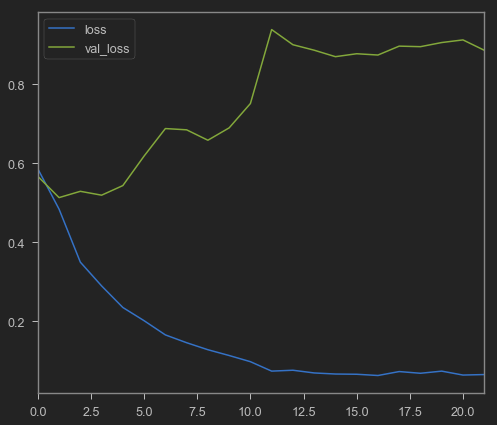

In [112]:
# Visualize loss and val_loss

pd.DataFrame(metrics).plot(y=["loss","val_loss"])

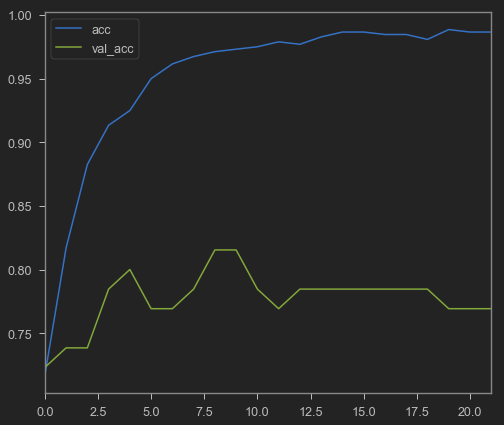

In [113]:
# Visualize accuracy and validation accuracy

pd.DataFrame(metrics).plot(y=["acc","val_acc"])

#### We can see that the validation loss started to decrease sharply after 3 epochs

In [3]:
# Load model

model = load_model('./model/LSTM_TH.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [16]:
# Evaluate with test set

yhat = model.predict_classes(X_test)
yhat_prob = model.predict_proba(X_test)
report = classification_report(y_test, yhat)
con_mat = confusion_matrix(y_test, yhat, labels=[1,0])
yhat_dummy = to_categorical(yhat)

In [17]:
print(report)

              precision    recall  f1-score   support

           0       0.58      0.65      0.61        17
           1       0.87      0.83      0.85        48

   micro avg       0.78      0.78      0.78        65
   macro avg       0.72      0.74      0.73        65
weighted avg       0.79      0.78      0.79        65



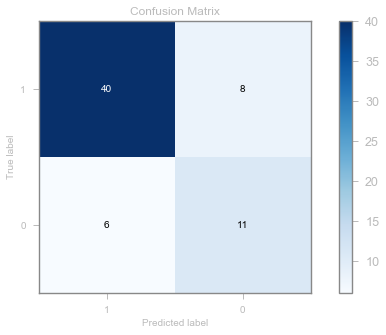

In [18]:
skplt.metrics.plot_confusion_matrix(y_test, yhat, labels=[1,0], figsize=(10,5))

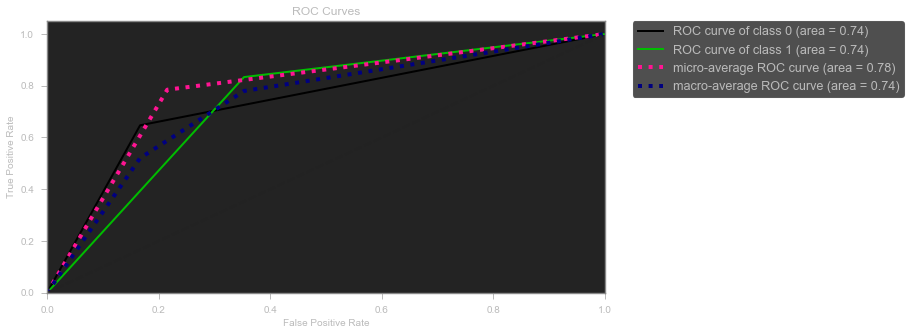

In [19]:
skplt.metrics.plot_roc(y_test, yhat_dummy, text_fontsize = 'medium', figsize = (10,5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

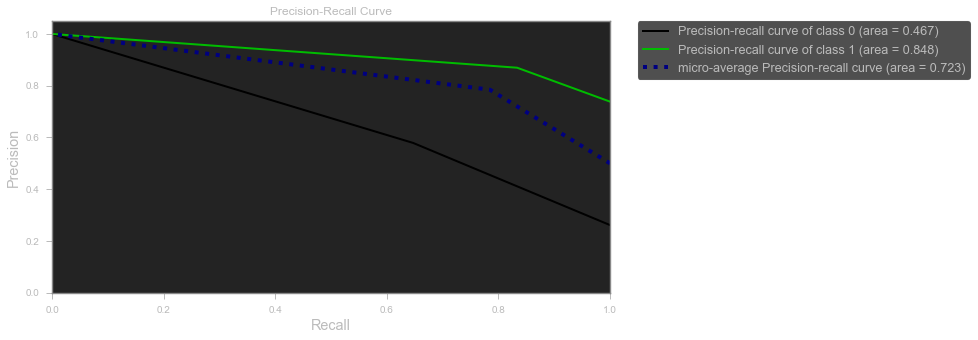

In [20]:
skplt.metrics.plot_precision_recall(y_test, yhat_dummy, text_fontsize = 'medium', figsize = (10,5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

These figures show that the model has good prediction for class 1 (positive comment) but predict badly for class 0 (negative comment). The model can be improve by having more negative comments.

### Analysis on Error

In [24]:
# Create dataframe to do analysis on error
df_X_test_copy = df_X_test.copy()

# Reset index
df_X_test_copy.reset_index(drop=True, inplace=True)

# Insert new column yhat
df_X_test_copy["yhat"] = pd.DataFrame(yhat, columns=['yhat'])

# Compare y ground truth with yhat
df_X_test_copy['test'] = df_X_test_copy["score"] != df_X_test_copy["yhat"]

# Show comments
df_X_test_copy.loc[df_X_test_copy["test"] == True, ["comment_th", 'score', 'yhat', 'hospital']]

,comment_th,score,yhat,hospital
1,ถามอะไรหน่อยได้ไหม พอจะรู้จักใครที่เขามีปัญหาสุขภาพ เช่น คนที่อยากจะลดน้ำหนัก กระชับสัดส่วน ต้นแขนต้นขา หน้าท้อง เพิ่มน้ำหนัก อยากผิวขาว มีออร่า สิว เพิ่มหน้าอก อยากเพิ่มนาด ใหญ่ ยาว อึด ทน นาน เพิ่มน้ำ เพิ่มรอบให้ยาวนาน และคนที่มีปัญหาเรื่องการขับถ่าย อย่าง-วันถ่ายที่และญาติผู้ใหญ่เป็นโรค ประจำ เช่นความดันเบาหวานโรคหัวใจโรคมะเร็ง ถ้ามีช่วยแนะนำให้ด้วยนะ ขอบคุณมากๆๆจร้า,1,0,rama
6,การรักษาถือว่าโอเครนะคร๊ แต่เรื่องที่จอดรถควรปรับปรุงเป้นอย่างมาก เพราะผู้ป่วยมาหาหมอแต่ละทีไม่มีที่จอดรถเลย ในโรงบาลก้อบอกให้จอดได้แต่เจ้าหน้า ตายห่าพอดีแระ คนป่วยรึญาติมาเยี่ยมผู้ป่วยต้องไปรถไว้ปั้มน้ำมันแล้วนั่งแท็กซี่มา แล้วจะมารถส่วนตัวไว้เพื่อ โรงบาลก้อใหญ่ แระ รวย แนะนำนะคร๊ทำที่รถเหมือนในห้างเลยคร๊ ทำหลายๆชั้นเพื่อรองรับคุนหมอ พยาบาลแระเจ้าหน้า ผู้ป่วยไม่ต้องสนใจหรอกคร๊,0,1,rama
9,คนไข้จำนวนมาก อาจต้องรอนานหน่อย แต่การรักษาเป็นมาตรฐาน,1,0,siriraj
11,ตั้งแต่ ปีที่ผ ่านมาบริการดีมากแต่ระยะหลังนี้หล้าช้ามากค่ะ,1,0,rama
15,คนเยอะรอนานหน่อยแต่ก็ดี,1,0,chula
23,ด้วยขื่อเสียงที่มีมายาวนาน และมีคนใกล้ชิดเข้ารับการรักษา และดิฉันก็เป็นหนึ่งในผู้บริจาคให้มูลนิธิรามาธิบดีมาอย่างยาวนาน แต่พอคุณพ่อเข้ารับการรักษาในห้องอุบัติเหตุและฉุกเฉิน ไม่ได้รับการดูแลอย่างที่ควร ผนวกกับไม่มีห้อง เจ้าหน้าที่ โดยเฉพาะพยาบาลและเจ้ากน้าที่พูดจาไม่ดีเลย สุดท้ายต้องย้ายโรงพยาบาลค่ะ,0,1,rama
31,คุณภาพให้ที่เลยค่ะ >,1,0,chula
48,ขอบคุณที่ดูแลร่างกายฉันตลอดปีก็มาที่นี่ดูแลกันที่นี่คลอดก็ที่นี่คนทุกคนต้องมีการซ่อมแซม ขอให้พระราชินีทั้งสามพระองค์ทรงพระเจริญ ผู้ก่อตั้งโรงบยาบาล,0,1,chula
49,เรารักษาที่นี้ครั้งแรกด้วยอาการซึมเศร้า พยาบาลยิ้ม น่ารัก พูดเพราะทุกๆคนเลย เขาไม่แสดงออกเลยว่าหงุดหงิด หรือรำคาญผู้ป่วยที่แสดงออกเสียงดัง หรือควบคุมไม่ได้ เราไม่รู้สึกว่าตัวเองเป็นคนแปลกแยก กลับมีเพื่อนคุยในเรื่องคล้ายๆกัน ระหว่างรอคุณหมอ คุณหมอทุกท่านใจดีมากๆเลย เภสัชก็น่ารัก เราเลือกไม่ผิดจริงๆที่รักษาที่นี้ เรารักศิริราชมากๆเลย,1,0,siriraj
50,การบริการของหมอและพยาบาลดีมาก แต่ควรปรับปรุงคือเรื่องเวลา รอตรวจนานมาก รอรับยานานมากเช่นกันค่ะ,1,0,rama


The error produced the model are due to:-
1. Some of the comments are ambigious that contain both positive and negative sentiment (6, 9, 11, 15, 50)
2. Some comments are question not sentiment (1, 59)
3. Some comments are incorrectly predicted (23, 48, 49, 55, 62, 63)

From the analysis, the model could be confused by having comments that contain both positive and negative sentiment. Which could lead to incorrect prediction.